# Deploy Mistral NeMo from Bedrock Marketplace & It's Capabilities

## Mistral Nemo Instruct 2407 Model

In this notebook, you learn how you can deploy Mistral NeMo Instruct model from Bedrock Marketplace and use the model using Converse APIs.
Mistral NeMo is a state-of-the-art 12B model with **128k context length**, built in collaboration with NVIDIA, and released under the Apache 2.0 license. The Mistral-Nemo-Instruct-2407 Large Language Model (LLM) is an instruct fine-tuned version of the Mistral-Nemo-Base-2407. NeMo is trained jointly by Mistral AI and NVIDIA, it significantly outperforms existing models smaller or similar in size.

**Key features**

Mistral NeMo features a 128k token context window, enabling processing of extensive long-form content. The model demonstrates strong performance in reasoning, world knowledge, and coding accuracy. Both pre-trained base and instruction-tuned checkpoints are available under the Apache 2.0 license, making it accessible for researchers and enterprises. The model’s quantization-aware training facilitates optimal FP8 inference performance without compromising quality.

- Released under the Apache 2 License
- Pre-trained and instructed versions
- Trained with a 128k context window
- Trained on a large proportion of multilingual and code data
- Drop-in replacement of Mistral 7B

Mistral Nemo is a transformer model, with the following architecture choices:

- Layers: 40
- Dim: 5,120
- Head dim: 128
- Hidden dim: 14,336
- Activation Function: SwiGLU
- Number of heads: 32
- Number of kv-heads: 8 (GQA)
- Vocabulary size: 2\*\*17 ~= 128k
- Rotary embeddings (theta = 1M)

**Input**

- Input Type: Text
- Input Format: String
- Input Parameters: max_tokens, temperature, top_p, stop, frequency_penalty, presence_penalty, seed

**Output**

- Output Type: Text
- Output Format: String

**Software Integration**

- Supported Hardware Platform(s): NVIDIA Hopper
- Preferred Operating System(s): Linux

### Benchmarks

The following table compares the accuracy of the Mistral NeMo base model with two popular open-source pre-trained models, Gemma 2 9B, and Llama 3 8B.

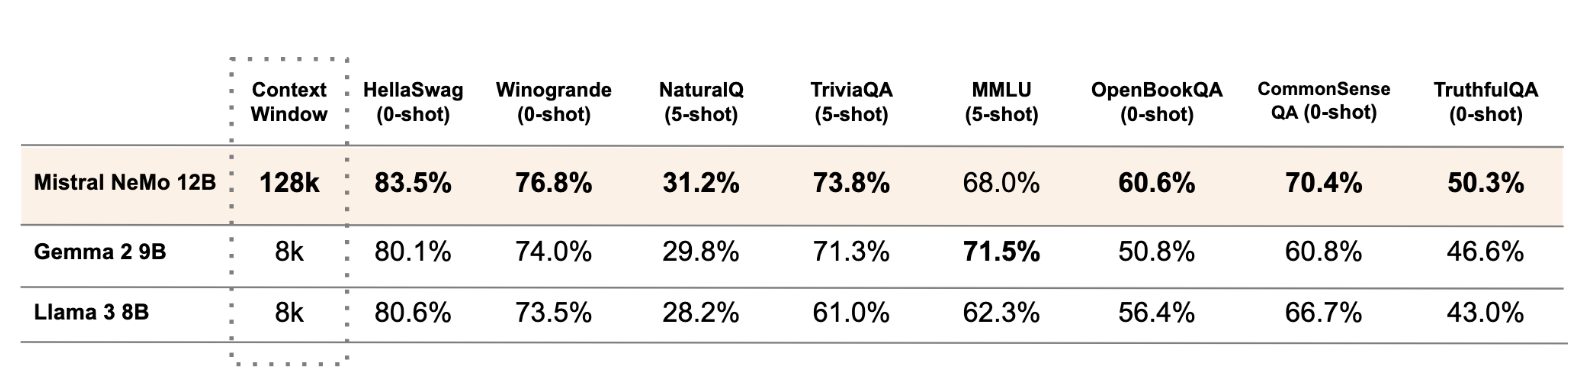

### Multilingual Capabilities

The model is designed for global, multilingual applications. It is trained on function calling, has a large context window, and is particularly strong in **English, French, German, Spanish, Italian, Portuguese, Chinese, Japanese, Korean, Arabic, and Hindi**. This is a new step toward bringing frontier AI models to everyone’s hands in all languages that form human culture.

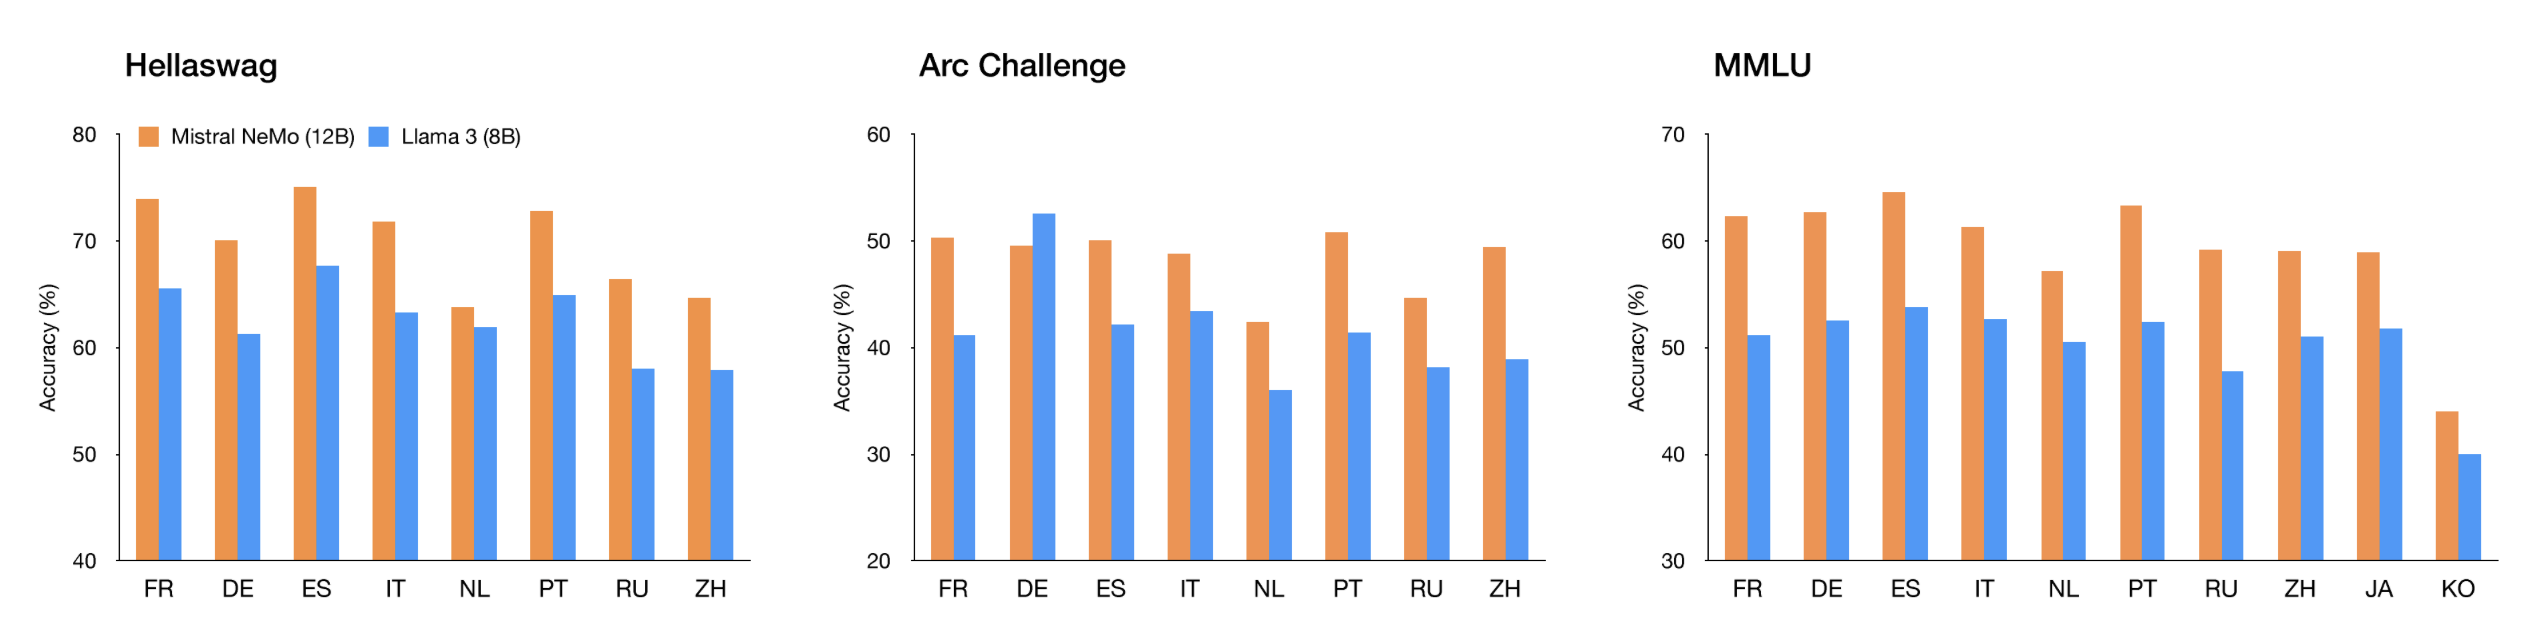

References:  
[Mistral AI Blog](https://mistral.ai/news/mistral-nemo/)  
[NVIDIA Model Card](https://build.nvidia.com/nv-mistralai/mistral-nemo-12b-instruct/modelcard)  
[AWS Blog](https://aws.amazon.com/blogs/machine-learning/mistral-nemo-instruct-2407-and-mistral-nemo-base-2407-are-now-available-on-sagemaker-jumpstart/)


## Setup Dependencies

This notebook uses boto3 and sagemaker modules. Make sure latest versions are installed


In [1]:
%pip install --upgrade pip
%pip install botocore boto3 sagemaker --upgrade --quiet


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the necessary libraries for grabbing sagemaker execution role, bedrock and bedrock runtime API operations


In [2]:
import boto3
import json
import sagemaker
import time
from botocore.exceptions import ClientError

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Deploy Model from Bedrock Marketplace


Set default configurations. Copy model source arn from Bedrock Marketplace catalog.


In [3]:
# Set configuration
MODEL_SOURCE_ID = 'huggingface-llm-mistral-nemo-instruct-2407'
MODEL_SOURCE_ARN = 'arn:aws:sagemaker:{region}:aws:hub-content/SageMakerPublicHub/Model/huggingface-llm-mistral-nemo-instruct-2407/1.0.3'
INSTANCE_TYPE = 'ml.g6.12xlarge'
ENDPOINT_NAME = 'nemo-on-bedrock'

Grab session role, region and aws account number.

IMPORTANT:
IAM Role must have permissions to create SageMaker endpoint and use marketplace models. Detailed guidance on policy is documented in [Bedrock User Guide](https://docs.aws.amazon.com/bedrock/latest/userguide/setup-amazon-bedrock-marketplace.html).


In [4]:
# function to grab aws account id, sagemaker execution role and region
def get_current_session_info():
    sagemaker_role_arn = sagemaker.get_execution_role()
    session = sagemaker.Session()
    account_id = session.account_id()
    region = session._region_name

    return account_id, region, sagemaker_role_arn

aws_account_id, aws_region, sagemaker_role_arn = get_current_session_info()

print(f'aws region: {aws_region}')

MODEL_SOURCE_ARN = MODEL_SOURCE_ARN.format(region=aws_region)


aws region: us-west-2


In [5]:
# Create bedrock client object
bedrock_client = boto3.client('bedrock')

In [6]:
# create bedrock marketplace endpoint
def create_endpoint(model_source_arn: str, 
                    endpoint_name: str,
                    instance_type: str, 
                    instance_count: int = 1):

    response = bedrock_client.create_marketplace_model_endpoint(
            modelSourceIdentifier=model_source_arn,
            endpointConfig={
                'sageMaker': {
                    'initialInstanceCount': instance_count,
                    'instanceType': instance_type,
                    'executionRole': sagemaker_role_arn,
                }
            },
            acceptEula=True,
            endpointName=endpoint_name
        )
    return response

create_response = create_endpoint(model_source_arn=MODEL_SOURCE_ARN, endpoint_name=ENDPOINT_NAME, instance_type=INSTANCE_TYPE)


In [7]:
# Retrieve endpoint arn from response text

endpoint_arn = create_response['marketplaceModelEndpoint']['endpointArn']


In [8]:
# Check endpoint creation status until it's in service

while(True):
    endpoint_reponse = bedrock_client.get_marketplace_model_endpoint(endpointArn=endpoint_arn)
    status = endpoint_reponse['marketplaceModelEndpoint']['endpointStatus']
    print(f'endpoint status: {status}')
    if (status != 'Creating'):
        break

    # wait for 10 seconds
    time.sleep(10)

endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint sta

## Usage Examples


In [9]:
# Create bedrock runtime object

bedrock_runtime = boto3.client("bedrock-runtime")

In [10]:

# Helper function to invoke model using Converse API (without streaming)
def invoke_model(system_prompt: str, messages: list, display_usage=False):
    system = [ { "text": system_prompt } ]
    
    inf_params = {"max_tokens": 2000, "temperature": 1.0}
    
    response = bedrock_runtime.converse(modelId=endpoint_arn, 
                                        messages=messages,
                                        system=system,
                                        additionalModelRequestFields=inf_params)

    # Print Response
    output_message = response['output']['message']
    output_content = ''
    for content in output_message['content']:
        output_content = output_content.join(content['text'])

    if (display_usage):
        token_usage = response['usage']
        print("\t--- Token Usage ---")
        print(f"\tInput tokens:  {token_usage['inputTokens']}")
        print(f"\tOutput tokens:  {token_usage['outputTokens']}")
        print(f"\tTotal tokens:  {token_usage['totalTokens']}")
        
        print(f"\tLatency: {response['metrics']['latencyMs']}")

    
    return output_content

In [11]:
# Helper function to invoke model using Converse API with streaming
def invoke_model_with_stream(system_prompt: str, messages: list):
    system = [ { "text": system_prompt } ]
    
    inf_params = {"max_tokens": 2000, "temperature": 0.4}
    
    response = bedrock_runtime.converse_stream(modelId=endpoint_arn, 
                                        messages=messages,
                                        system=system,
                                        additionalModelRequestFields=inf_params)
    stream = response.get('stream')
    output_content = ''
    if stream:
        for event in stream:

            if 'messageStart' in event:
                print(f"\nRole: {event['messageStart']['role']}")

            if 'contentBlockDelta' in event:
                print(event['contentBlockDelta']['delta']['text'], end="")
                output_content = output_content.join(event['contentBlockDelta']['delta']['text'])

            if 'messageStop' in event:
                print(f"\nStop reason: {event['messageStop']['stopReason']}")

            if 'metadata' in event:
                print(event)
                metadata = event['metadata']
                if 'usage' in metadata:
                    print("\nToken usage")
                    print(f"Input tokens: {metadata['usage']['inputTokens']}")
                    print(
                        f":Output tokens: {metadata['usage']['outputTokens']}")
                    print(f":Total tokens: {metadata['usage']['totalTokens']}")
                if 'metrics' in event['metadata']:
                    print(
                        f"Latency: {metadata['metrics']['latencyMs']} milliseconds")

    return output_content


### Text Generation


Ask question on history


In [12]:
messages = [
    {
        "role": "user",
        "content": [{"text": 'What is the history behind the Napoleonic Wars?'}]
    }
]

output = invoke_model('You are a renowned historian.', messages)
print(f'Response: \n{output}')

Response: 
The Napoleonic Wars, a series of conflicts fought between Napoleonic France and various European coalitions, span nearly two decades, from 1803 to 1815. Here's a brief history of this significant period:

1. **Revolutionary Wars (1792-1802)**: The Napoleonic Wars began as a continuation of the French Revolutionary Wars. In 1789, the French Revolution overthrew the Bourbon monarchy and established the First French Republic. The new government, seeking to export its ideals and secure France's borders, invaded neighboring countries. The initial conflicts were typically engaged against Austria, Prussia, and other European powers alarmed by France's revolutionary fervor.

2. **Napoleon Bonaparte's Rise to Power (1795-1799)**: A young military officer named Napoleon Bonaparte distinguished himself during the Revolution and rose through the ranks. He played a significant role in several major victories, including the Battle of the Pyramids (1798) and the Battle of the Bridge of Arc

### Text Summarization


In [13]:
prompt = '''
In recent years, machine learning (ML) has moved from research and development to the mainstream, driven by the increasing number of data sources and scalable cloud-based compute resources. AWS’ customers currently use AI/ML for a wide variety of applications such as call center operations, personalized recommendations, identifying fraudulent activities, social media content moderation, audio and video content analysis, product design services, and identity verification. Industries using AI/ML include healthcare and life sciences, industrial and manufacturing, financial services, media and entertainment, and telecom.

Machine learning, through its use of algorithms to find patterns in data, can bring considerable power to its customers and thus recommends responsibility in its use. AWS is committed to developing fair and accurate AI and ML services and providing you with the tools and guidance needed to build AI and ML applications responsibly. For more information on this important topic, refer to AWS' Responsible AI.

This whitepaper provides you with a set of proven best practices. You can apply this guidance and architectural principles when designing your ML workloads, and after your workloads have entered production as part of continuous improvement. Although the guidance is cloud- and technology-agnostic, the paper also includes guidance and resources to help you implement these best practices on AWS.

The AWS Well-Architected Framework helps you understand the benefits and risks of decisions you make while building workloads on AWS. By using the Framework, you learn operational and architectural best practices for designing and operating workloads in the cloud. It provides a way to consistently measure your operations and architectures against best practices and identify areas for improvement.

Your ML models depend on the quality of input data to generate accurate results. As data changes with time, monitoring is required to continually detect, correct, and mitigate issues with accuracy and performance. This monitoring step might require you to retrain your model over time using the latest refined data.

While application workloads rely on step-by-step instructions to solve a problem, ML workloads enable algorithms to learn from data through an iterative and continuous cycle. The ML Lens complements and builds upon the Well-Architected Framework to address this difference between these two types of workloads.

This paper is intended for those in a technology role, such as chief technology officers (CTOs), architects, developers, data scientists, and ML engineers. After reading this paper, you will understand the best practices and strategies to use when you design and operate ML workloads on AWS.

'''


messages = [
    {
        "role": "user",
        "content": [{"text": prompt}]
    }
]

output = invoke_model('You are a technical writer. Summarize this technical content.', messages)
print(f'Response: \n{output}')

Response: 
**Summary:**

- **Machine Learning (ML) Adoption:** ML has become mainstream, driven by increased data sources and scalable cloud computing, with AWS customers using it in various applications across industries like healthcare, finance, media, and telecom.

- **Responsible AI/ML:** AWS emphasizes responsible AI/ML use, providing tools and guidelines for building fair and accurate applications. Refer to AWS' 'Responsible AI' for more information.

- **Best Practices & Architecture:** This whitepaper offers best practices and architectural principles for designing and continuously improving ML workloads, with cloud-agnostic guidance and AWS-specific resources.

- **AWS Well-Architected Framework:** This framework helps assess and improve ML workloads, providing consistent measurement against best practices and identifying areas for enhancement.

- **Data Quality & Monitoring:** ML models rely on input data quality. Regular monitoring is essential to maintain accuracy and perfo

### Text Classification


In [14]:
system_prompt = '''
You are an AI assistant tasked with classifying data based on its sensitivity level. The sensitivity levels and their definitions are:

Sensitive: Data that is to have the most limited access and requires a high degree of integrity. This is typically data that will do the most damage to the organization should it be disclosed.
Confidential: Data that might be less restrictive within the company but might cause damage if disclosed.
Private: Private data is usually compartmental data that might not do the company damage but must be kept private for other reasons. Human resources data is one example of data that can be classified as private.
Proprietary: Proprietary data is data that is disclosed outside the company on a limited basis or contains information that could reduce the company's competitive advantage, such as the technical specifications of a new product.
Public: Public data is the least sensitive data used by the company and would cause the least harm if disclosed. This could be anything from data used for marketing to the number of employees in the company.

For each user inquery provided, classify it into one of the above sensitivity levels. Do not include the word "Category". Do not provide explanations or notes.
'''

In [15]:
messages = [
    {
        "role": "user",
        "content": [{"text": "I'm an HR recruiter. What data classifiction category are resumes gathered based on referral by employees?"}]
    }
]

output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
Private


In [16]:
messages = [
    {
        "role": "user",
        "content": [{"text": "I require the financial statements for the past three fiscal years."}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
Sensitive


In [17]:
messages = [
    {
        "role": "user",
        "content": [{"text": "Company's source code"}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
Sensitive


In [18]:
messages = [
    {
        "role": "user",
        "content": [{"text": "I need access to the personnel files containing employee social security numbers and financial information."}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
Sensitive


In [19]:
messages = [
    {
        "role": "user",
        "content": [{"text": "Quarterly regulatory filings with the exchanges"}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
Public


In [20]:
bedrock_client.deregister_marketplace_model_endpoint(endpointArn=endpoint_arn)
bedrock_client.register_marketplace_model_endpoint(modelSourceIdentifier=MODEL_SOURCE_ARN, endpointIdentifier=endpoint_arn)

{'ResponseMetadata': {'RequestId': '3eb7f78e-3eba-4ab2-baa8-49c666cdacc1',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 02 Jan 2025 14:25:13 GMT',
   'content-type': 'application/json',
   'content-length': '812',
   'connection': 'keep-alive',
   'x-amzn-requestid': '3eb7f78e-3eba-4ab2-baa8-49c666cdacc1'},
  'RetryAttempts': 0},
 'marketplaceModelEndpoint': {'endpointArn': 'arn:aws:sagemaker:us-west-2:074598462996:endpoint/nemo-on-bedrock',
  'modelSourceIdentifier': 'arn:aws:sagemaker:us-west-2:aws:hub-content/SageMakerPublicHub/Model/huggingface-llm-mistral-nemo-instruct-2407/1.0.3',
  'status': 'REGISTERED',
  'statusMessage': '',
  'createdAt': datetime.datetime(2025, 1, 2, 14, 25, 13, 180235, tzinfo=tzlocal()),
  'updatedAt': datetime.datetime(2025, 1, 2, 14, 25, 13, 180235, tzinfo=tzlocal()),
  'endpointConfig': {'sageMaker': {'initialInstanceCount': 1,
    'instanceType': 'ml.g6.12xlarge'}},
  'endpointStatus': 'InService'}}

### Email Draft - Raw to Professional


NeMo can be a good model for drafting professional email content.


In [21]:
system_prompt = '''
hi, this is to inform u that you that u don't qualify for this offer.

rgds,
support team
'''

messages = [
    {
        "role": "user",
        "content": [{"text": "You are a professional customer support agent. Your messages are always polite and helpful. You need to re-draft poorly written emails to professional language and tone."}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
Dear [Customer's Name],

I regret to inform you that, after careful consideration, we have determined that your application does not meet the qualifications for this particular offer at this time.

We understand that this may be disappointing, and we appreciate your interest in our services. Please note that we have many other offers and promotions that you may qualify for in the future. We encourage you to keep an eye on our website and social media channels for updates.

In the meantime, if you have any questions or concerns, or if there is any other way we can assist you, please do not hesitate to reach out. Our support team is always here to help.

Thank you for considering our services, and we look forward to the possibility of serving you in the future.

Best regards,

[Your Name]
Support Team


### Sentiment Analysis


Below examples demonstrate sentiment analysis capabilities of the model.


In [22]:
system_prompt = '''
Analyze the sentiments of given news headlines, determine if it is positive, neutral, or negative, and return the answer as the corresponding sentiment label "positive" or "neutral" or "negative"
'''

In [23]:
messages = [
    {
        "role": "user",
        "content": [{"text": "a January 11 , 2010 EPHC board of directors has approved an increase in the quarterly dividend from $ 0.03 to $ 0.05 per share"}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
The given news headline "a January 11, 2010 EPHC board of directors has approved an increase in the quarterly dividend from $ 0.03 to $ 0.05 per share" has a positive sentiment as it conveys a positive action (increase in dividend). Therefore, the answer is "positive".


In [24]:
messages = [
    {
        "role": "user",
        "content": [{"text": "The company decided at the end of 2008 to temporarily shut down its ammonia plant in Billingham and extend the maintenance period at its Ince facility"}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
"negative"

The phrase "shut down" and "extend the maintenance period" both suggest negative sentiments as they imply closure or halt of operations, which is unfavorable for a company. The use of "temporarily" does not negate the negative sentiment in this context.


In [25]:
messages = [
    {
        "role": "user",
        "content": [{"text": "The center offers a comprehensive range of device design services spanning from electronics , mechanics and software design to a full range of testing laboratory services"}]
    }
]
output = invoke_model(system_prompt, messages)
print(f'Response: \n{output}')

Response: 
To analyze the sentiment of the given news headline, we'll use a simple rule-based approach since there's no clear sentiment trigger words or phrases. Here's how we can determine the sentiment:

1. The headline mentions a "comprehensive range of device design services" and "full range of testing laboratory services."
2. These phrases suggest that the center is capable and extensive in its offerings.
3. There are no negative or positive trigger words in the headline.

Based on this analysis, the sentiment of the given news headline is **neutral**.

Here's the sentiment label:

"neutral"


### Code Generation


Below cells demonstrate code generation capabilities of NeMo.


In [26]:
messages = [
    {
        "role": "user",
        "content": [{"text": 'Create a React component that calculates body mass index.'}]
    }
]

output = invoke_model('You are a software engineer with expertise on React.', messages)
print(f'Response: \n{output}')

Response: 
Here's a simple React component that calculates Body Mass Index (BMI) when the user enters their weight and height. This component also displays the BMI category based on World Health Organization's guidelines.

```jsx
import React, { useState } from 'react';

const BmiCalculator = () => {
  const [weight, setWeight] = useState(0);
  const [height, setHeight] = useState(0);
  const [bmi, setBmi] = useState(null);
  const [category, setCategory] = useState('');

  const calculateBmi = (e) => {
    e.preventDefault();
    if (weight > 0 && height > 0) {
      const bmiValue = (weight / ((height / 100) * (height / 100))).toFixed(2);
      setBmi(bmiValue);

      if (bmiValue < 18.5) {
        setCategory('Underweight');
      } else if (bmiValue >= 18.5 && bmiValue < 24.9) {
        setCategory('Normal weight');
      } else if (bmiValue >= 25 && bmiValue < 29.9) {
        setCategory('Overweight');
      } else if (bmiValue >= 30) {
        setCategory('Obesity');
      }
   

In [27]:
prompt = '''
Create a Python script for a Jupyter notebook that fetches stock market data for NVIDIA (NVDA) and Apple (AAPL) and performs analysis with interactive visualizations. The script should:

Use the yfinance library to fetch stock data for NVDA and AAPL for the last 6 months.
Implement data analysis functions to:

Calculate daily returns
Compute 20-day moving average


Create interactive visualizations using Plotly, including:

A line chart comparing both stocks' performance and their 20-day moving averages
A bar chart showing daily returns for the selected stock


Use ipywidgets to create:

A dropdown menu to select which stock to display in the bar chart
A button to refresh the data


Include error handling for API calls and data processing.
Add brief comments explaining key parts of the code.

The final output should be a single Python script that can be run in a Jupyter notebook cell, creating an interactive dashboard for stock analysis of NVDA and AAPL.
Ensure all necessary libraries are imported at the beginning of the script. The code should be well-structured and follow Python best practices.
Note: Real-time updating is not required; fetching data once when the script runs and on button click is sufficient.
'''

messages = [
    {
        "role": "user",
        "content": [{"text": prompt}]
    }
]

output = invoke_model('You are a software engineer with expertise on python.', messages)
print(f'Response: \n{output}')

Response: 
Here's a Python script that meets your requirements and can be run in a Jupyter notebook. Make sure you have the necessary libraries installed (`yfinance`, `plotly`, `ipywidgets`).

```python
# Import necessary libraries
import yfinance as yf
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime, timedelta

# Define the tickers and the time period for data fetching
tickers = ['NVDA', 'AAPL']
start_date = (datetime.now() - timedelta(days=180)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

# Function to fetch data and perform analysis
def fetch_and_analyze_data():
    try:
        # Fetch data using yfinance
        data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

        # Calculate daily returns
        data_returns = data.pct_change()

        # Compute 20-day moving average
        data['20-day MA'] = data.rolling(window=20).mean()

     

## Cleanup


Do not forget to cleanup your resources to avoid endpoint costs in your account


In [28]:
bedrock_client.delete_marketplace_model_endpoint(endpointArn=endpoint_arn)

{'ResponseMetadata': {'RequestId': 'b12d4892-5ff7-4f1f-b84a-46de74130093',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 02 Jan 2025 14:25:58 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'b12d4892-5ff7-4f1f-b84a-46de74130093'},
  'RetryAttempts': 0}}